# Train Simulator

Requires fitting three models:
+ a user choice model
+ a single or set of recommender models
+ a user visit model

In [1]:
import paths
%cd {paths.base}
from os.path import join

%load_ext autoreload
%autoreload 2
from simtrain import process_dat, sim_models, explore_models, utils
from simtrain import SETTINGS_POLIMI as SETTINGS
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import scipy
from scipy import stats, sparse
import shutil
from datetime import datetime
import os
os.environ['NUMEXPR_MAX_THREADS'] = SETTINGS.NUMEXPR_MAX_THREADS

/home/thahit/github/Recommender_Sim
loaded sim_models


In [2]:
print(SETTINGS.simulation_components)
ab_test_id = SETTINGS.simulation_components['ab_test_id']
input_data_path = join(paths.dat, SETTINGS.rootpaths['input'])
full_data_path = join(input_data_path, SETTINGS.filepaths['impressions_data_test']) % ab_test_id
subset_data_path = full_data_path + '_subset'

cell_col = 'acnt.test_cell_nbr'
cells = {'train':1,
        'valid':2,
        'test_seen_users':3,
        'test_unseen_users':4}

{'ab_test_id': 'train', 'rec_model_cell_nbr': [1], 'user_model_cell_nbr': 1, 'visit_model_cell_nbr': 1}


In [41]:
train_dat, stg = process_dat.load_dat(paths.cw_stages['output']['train'])
print('settings',stg)
train_dat

loaded sim_models
settings {'NI': 302, 'NU': 328, 'T': 69.9892349243164, 'NS': 100, 'INF_TIME': 1000}


,Unnamed: 0,Unnamed: 0.1,user_id,time,action,state,rec_id,reward,round_time
0,1,1,188,5.418762,119,,0,False,5.416667
1,2,2,188,5.418762,74,,0,True,5.416667
2,3,3,188,5.418762,132,74,0,False,5.416667
3,4,4,188,5.418762,195,74,0,False,5.416667
4,5,5,188,5.418762,249,74,0,False,5.416667
...,...,...,...,...,...,...,...,...,...
1168398,3112319,3112319,42063,29.539190,57,204:204:204:166:265:163:202:202:199:273:95:244...,1,False,29.541667
1168399,3112320,3112320,42063,29.539190,217,204:204:204:166:265:163:202:202:199:273:95:244...,1,False,29.541667
1168400,3112321,3112321,42063,29.539190,205,204:204:204:166:265:163:202:202:199:273:95:244...,1,False,29.541667
1168401,3112322,3112322,42063,29.539190,66,204:204:204:166:265:163:202:202:199:273:95:244...,1,False,29.541667


In [43]:
train_dat.drop(['Unnamed: 0.1', "Unnamed: 0"], axis=1, inplace=True)

Index(['user_id', 'time', 'action', 'state', 'rec_id', 'reward', 'round_time'], dtype='object')

In [4]:
validation_dat, _ = process_dat.load_dat(paths.cw_stages['output']['validate'])
test_seen_users_dat, _ = process_dat.load_dat(paths.cw_stages['output']['test-seen'])
test_unseen_users_dat, _ = process_dat.load_dat(paths.cw_stages['output']['test-unseen'])

In [5]:
# combine all into one dataframe with new column indicating "cell", i.e. train = 1, validate = 2, test seen = 3, test unseen = 4
train_dat[cell_col] = cells['train']
validation_dat[cell_col] = cells['valid']
test_seen_users_dat[cell_col] = cells['test_seen_users']
test_unseen_users_dat[cell_col] = cells['test_unseen_users']
all_dat = pd.concat([train_dat, validation_dat, test_seen_users_dat, test_unseen_users_dat], ignore_index = True)
simulation = all_dat

In [6]:
# combine all into one dataframe with new column indicating "cell", i.e. train = 1, validate = 2, test seen = 3, test unseen = 4
train_dat[cell_col] = cells['train']
validation_dat[cell_col] = cells['valid']
test_seen_users_dat[cell_col] = cells['test_seen_users']
test_unseen_users_dat[cell_col] = cells['test_unseen_users']
all_dat = pd.concat([train_dat, validation_dat, test_seen_users_dat, test_unseen_users_dat], ignore_index = True)
simulation = all_dat

In [7]:
# finally calculate settings dict from all data:
stg = process_dat.get_settings(all_dat)
print('settings',stg)

settings {'NI': 302, 'NU': 481, 'T': 97.99586486816406, 'NS': 100, 'INF_TIME': 1000}


In [8]:
print('summary stats of data splits:')
for i in range(1,5):
    print('cell %i:' % i, all_dat[all_dat['acnt.test_cell_nbr']==i].time.count(), 'impressions')

summary stats of data splits:
cell 1: 1168403 impressions
cell 2: 505067 impressions
cell 3: 320285 impressions
cell 4: 144652 impressions


In [9]:
# num users in each cell
for i in range(1,5):
    print('num users in cell %i:' % i,simulation[simulation['acnt.test_cell_nbr']==i].user_id.nunique())

num users in cell 1: 328
num users in cell 2: 143
num users in cell 3: 244
num users in cell 4: 110


In [10]:
# create subset of data for hyperparameter selection:
np.random.seed(87)
hyp_sub_sim = simulation.sample(n=100000)

In [11]:
intermediate_path = paths.cw_stages['output']['alldat']
hyp_subset_path = paths.cw_stages['output']['hypsubset']

In [12]:
all_dat.reset_index(drop=True).to_csv(intermediate_path, index=False)
hyp_sub_sim.reset_index(drop=True).to_csv(hyp_subset_path, index=False)

In [13]:
intermediate_path

'/home/thahit/github/Recommender_Sim/ContentWiseImpressions/data/ContentWiseImpressions/CW10M-CSV/ContentWise-alldat-subitems.csv.gz'

In [14]:
all_dat,_ = process_dat.load_dat(intermediate_path)
hyp_sub_sim,_ = process_dat.load_dat(hyp_subset_path)
stg = process_dat.get_settings(all_dat)

In [15]:
# take a subset of users in each cell:
subset_usr_slice_1 = all_dat[all_dat['acnt.test_cell_nbr']==1].user_id.sample(n=100)
sub_sim = all_dat[all_dat['user_id'].isin(subset_usr_slice_1)].reset_index(drop=True)

### Fit Models to Minimize Sim2Real Gap
and save to disk

### Rec model hyperparameter selection

hyperparameters to select over:
+ n_nodes per first layer = [500, 1000, 2000]
+ n_nodes per second layer = [0, 100, 500]
+ alpha for popularity attenuation = [0., 0.05, 0.1, 0.2]

strategy:
+ select architecture, pick one that minimizes loss on validation data
+ then select alpha based on min loss on validation data

Text(0, 0.5, 'weight adjustment')

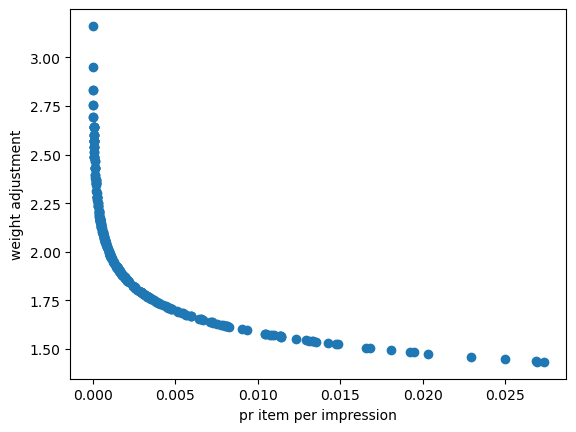

In [16]:
hyp_dat_ac = hyp_sub_sim.groupby('action').action.count()
pr_item = hyp_dat_ac / hyp_sub_sim.shape[0]
weights = 1/(pr_item**0.1)
weight_df = weights.to_frame().rename(columns={'action':'weight'})
ys = weights.values
plt.scatter(pr_item, ys)
plt.xlabel('pr item per impression')
plt.ylabel('weight adjustment')

In [17]:
# define hyp configuration as operation on the hyp dict:
rec_hyp_points = [{'n_hidden_layers':1, 'n_nodes':[500]},
                  {'n_hidden_layers':1, 'n_nodes':[1000]},
                  {'n_hidden_layers':1, 'n_nodes':[2000]},
                  {'n_hidden_layers':2, 'n_nodes':[500,100]},
                  {'n_hidden_layers':2, 'n_nodes':[500,500]},
                  {'n_hidden_layers':2, 'n_nodes':[1000,100]},
                  {'n_hidden_layers':2, 'n_nodes':[1000,500]},
                  {'n_hidden_layers':2, 'n_nodes':[2000,500]},
                  {'popularity_alpha':0.05, 'n_hidden_layers':1, 'n_nodes':[1000]},
                  {'popularity_alpha':0.1, 'n_hidden_layers':1, 'n_nodes':[1000]},
                  {'popularity_alpha':0.2, 'n_hidden_layers':1, 'n_nodes':[1000]}]

# define settings global to all experiments in hyp selection:
rec_hyp_global =  {'dropout_rate': 0.15, 
                      'hidden_activation': 'relu',
                      'max_epoch': 1,
                      'min_delta': 0.01, 
                      'batch_size':2048,
                      'train_ips': False,
                       'popularity_alpha':0
                    }

def train_hyp_rec(dat, stg, hyp, hyp_points, global_hyp, seed=84):
    np.random.seed(seed)
    train_rows = (dat['acnt.test_cell_nbr']==cells['train'])
    rec_train = dat[train_rows].sample(n=10000)
    print('n train points', rec_train.shape[0])
    
    retval = [] # of form (model, all_hyp, delta_hyp)
    
    # define action popularity:
    dat_ac = dat.groupby('action').action.count()
    pr_item = dat_ac / dat.shape[0]
    weight_df = pr_item.to_frame().rename(columns={'action':'pr_item'})
    
    for hp in hyp_points:
        # update local copy of hyp:
        local_hyp = hyp.copy()
        print('updating with hp',hp)
        local_hyp.update(global_hyp)
        local_hyp.update(hp)
        print('training with hyp',local_hyp)
        
        # define weights:
        pop_alpha = local_hyp['popularity_alpha']
        if  pop_alpha > 0:
            weight_df['weight'] = 1/(weight_df.pr_item.values**pop_alpha)
            weights = rec_train.merge(weight_df, how='inner', on='action').weight
            print('weights shape',weights.shape)
        else:
            weights = np.ones(rec_train.shape[0])

        
        # define which cells to train on
        rec_cells = SETTINGS.simulation_components['rec_model_cell_nbr']
        NR = len(rec_cells)
        
        # train model
        rec_model = sim_models.RecModel(stg['NI'], stg['NI'], local_hyp)
        #rec_model.fit(rec_train, stg['NI'], W_=weights[:,np.newaxis])
        rec_model.fit(rec_train, stg['NI'], W_=weights)


        retval.append((rec_model, local_hyp, hp))
    
    return retval

rec_models = train_hyp_rec(hyp_sub_sim, stg, SETTINGS.hyp['rec_model_hyp'], rec_hyp_points, rec_hyp_global)

n train points 10000
updating with hp {'n_hidden_layers': 1, 'n_nodes': [500]}
training with hyp {'dropout_rate': 0.15, 'n_hidden_layers': 1, 'n_nodes': [500], 'hidden_activation': 'relu', 'max_epoch': 1, 'min_delta': 0.01, 'batch_size': 2048, 'train_ips': False, 'time_slots_per_day': 1.0, 'popularity_alpha': 0}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
	 decoding state:
stats of sparse matrix 0 9999 0 301 10000 302
	 one-hot encoding actions:


OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-21
OMP: Info #156: KMP_AFFINITY: 22 available OS procs
OMP: Info #158: KMP_AFFINITY: Nonuniform topology
OMP: Info #179: KMP_AFFINITY: 1 packages x 16 cores/pkg x 2 threads/core (16 total cores)
OMP: Info #214: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #171: KMP_AFFINITY: OS proc 12 maps to package 0 core 0 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 13 maps to package 0 core 1 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 14 maps to package 0 core 2 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 15 maps to package 0 core 3 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 16 maps to package 0 core 4 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 17 maps to package 0 core 5 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 18 maps to package 0 core 6 thread 0 
OMP: Info #171: K

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
1/5 [=====>........................] - ETA: 2s - loss: 5.7110 - acc: 0.0024

OMP: Info #250: KMP_AFFINITY: pid 16441 tid 16551 thread 1 bound to OS proc set 13
OMP: Info #250: KMP_AFFINITY: pid 16441 tid 16554 thread 2 bound to OS proc set 14
OMP: Info #250: KMP_AFFINITY: pid 16441 tid 16555 thread 3 bound to OS proc set 15
OMP: Info #250: KMP_AFFINITY: pid 16441 tid 16556 thread 4 bound to OS proc set 16
OMP: Info #250: KMP_AFFINITY: pid 16441 tid 16557 thread 5 bound to OS proc set 17
OMP: Info #250: KMP_AFFINITY: pid 16441 tid 16558 thread 6 bound to OS proc set 18
OMP: Info #250: KMP_AFFINITY: pid 16441 tid 16559 thread 7 bound to OS proc set 19
OMP: Info #250: KMP_AFFINITY: pid 16441 tid 16560 thread 8 bound to OS proc set 1
OMP: Info #250: KMP_AFFINITY: pid 16441 tid 16561 thread 9 bound to OS proc set 3
OMP: Info #250: KMP_AFFINITY: pid 16441 tid 16562 thread 10 bound to OS proc set 0
OMP: Info #250: KMP_AFFINITY: pid 16441 tid 16563 thread 11 bound to OS proc set 6
OMP: Info #250: KMP_AFFINITY: pid 16441 tid 16564 thread 12 bound to OS proc set 8
OMP: I

5/5 [==============================] - 1s 172ms/step - loss: 5.7037 - acc: 0.0125
updating with hp {'n_hidden_layers': 1, 'n_nodes': [1000]}
training with hyp {'dropout_rate': 0.15, 'n_hidden_layers': 1, 'n_nodes': [1000], 'hidden_activation': 'relu', 'max_epoch': 1, 'min_delta': 0.01, 'batch_size': 2048, 'train_ips': False, 'time_slots_per_day': 1.0, 'popularity_alpha': 0}
	 decoding state:
stats of sparse matrix 0 9999 0 301 10000 302
	 one-hot encoding actions:
5/5 [==============================] - 1s 174ms/step - loss: 5.6997 - acc: 0.0157
updating with hp {'n_hidden_layers': 1, 'n_nodes': [2000]}
training with hyp {'dropout_rate': 0.15, 'n_hidden_layers': 1, 'n_nodes': [2000], 'hidden_activation': 'relu', 'max_epoch': 1, 'min_delta': 0.01, 'batch_size': 2048, 'train_ips': False, 'time_slots_per_day': 1.0, 'popularity_alpha': 0}
	 decoding state:
stats of sparse matrix 0 9999 0 301 10000 302
	 one-hot encoding actions:
5/5 [==============================] - 1s 270ms/step - loss: 5

In [18]:
def save_hyp_rec_models(rec_models):
    # define file format based on delta hyp:
    hyp_ext = lambda delta_hyp: '_'.join([str(k)+'-'+str(v) for k,v in delta_hyp.items()])
    
    model_stem = join(paths.dat, SETTINGS.filepaths['rec_model_t_test'])
    model_stem_dir = join(paths.dat, 'rec_hyp_select')
    !mkdir {model_stem_dir}
    
    for (m,h,dh) in rec_models:
        target_path = join(model_stem_dir, 'rec_model_' + hyp_ext(dh))
        print('saving to target path',target_path)
        m.save(target_path)
    print('done.')
    
save_hyp_rec_models(rec_models)

mkdir: cannot create directory ‘/home/thahit/github/Recommender_Sim/dat/rec_hyp_select’: File exists
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[500]
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[1000]
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[2000]
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-2_n_nodes-[500, 100]
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-2_n_nodes-[500, 500]
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-2_n_nodes-[1000, 100]
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-2_n_nodes-[1000, 500]
saving to target path /home/thahit/github/

In [19]:
cells

{'train': 1, 'valid': 2, 'test_seen_users': 3, 'test_unseen_users': 4}

In [20]:
def eval_hyp_rec_models(dat, rec_models, stg, seed=78):
    np.random.seed(seed)
    #validation_rows = (dat['acnt.test_cell_nbr']==cells['test'])
    validation_rows = (dat['acnt.test_cell_nbr']==cells['valid'])
    rec_val = dat[validation_rows].sample(n=5000,replace=False)
    print('n rows in validation',rec_val.shape[0], 'n positive', rec_val[rec_val.reward>0].shape[0])
    
    retval = [] # of form (rec_model, all_hyp, delta_hyp, val_loss)
    
    is_feature_processed = False
    for i,(m,h,dh) in enumerate(list(rec_models)):    
        if not(is_feature_processed):
            Sv, Av = m.process_features(rec_val, stg['NI'])
            S = Sv.todense()
            A = Av.todense()
            is_feature_processed = True
        loss,acc = m._model.evaluate(S, A)
        print('delta_hyp',dh,'loss',loss)
        retval.append((m,h,dh,loss))
        
    return retval
        
rec_models_loss = eval_hyp_rec_models(hyp_sub_sim, rec_models, stg)

n rows in validation 5000 n positive 22
	 decoding state:
stats of sparse matrix 0 4999 0 299 5000 302
	 one-hot encoding actions:
5000/5000 [==============================] - 0s 69us/sample - loss: 5.6923 - acc: 0.0174
delta_hyp {'n_hidden_layers': 1, 'n_nodes': [500]} loss 5.692292493247986
5000/5000 [==============================] - 0s 91us/sample - loss: 5.6821 - acc: 0.0182
delta_hyp {'n_hidden_layers': 1, 'n_nodes': [1000]} loss 5.682052269363403
5000/5000 [==============================] - 1s 108us/sample - loss: 5.6665 - acc: 0.0218
delta_hyp {'n_hidden_layers': 1, 'n_nodes': [2000]} loss 5.666480140113831
5000/5000 [==============================] - 0s 82us/sample - loss: 5.6965 - acc: 0.0144
delta_hyp {'n_hidden_layers': 2, 'n_nodes': [500, 100]} loss 5.696544173240661
5000/5000 [==============================] - 0s 94us/sample - loss: 5.6725 - acc: 0.0224
delta_hyp {'n_hidden_layers': 2, 'n_nodes': [500, 500]} loss 5.672540876102447
5000/5000 [==============================

In [21]:
rec_models_loss

[(<simtrain.sim_models.RecModel at 0x791e6e4f0a10>,
  {'dropout_rate': 0.15,
   'n_hidden_layers': 1,
   'n_nodes': [500],
   'hidden_activation': 'relu',
   'max_epoch': 1,
   'min_delta': 0.01,
   'batch_size': 2048,
   'train_ips': False,
   'time_slots_per_day': 1.0,
   'popularity_alpha': 0},
  {'n_hidden_layers': 1, 'n_nodes': [500]},
  5.692292493247986),
 (<simtrain.sim_models.RecModel at 0x791e6dc32910>,
  {'dropout_rate': 0.15,
   'n_hidden_layers': 1,
   'n_nodes': [1000],
   'hidden_activation': 'relu',
   'max_epoch': 1,
   'min_delta': 0.01,
   'batch_size': 2048,
   'train_ips': False,
   'time_slots_per_day': 1.0,
   'popularity_alpha': 0},
  {'n_hidden_layers': 1, 'n_nodes': [1000]},
  5.682052269363403),
 (<simtrain.sim_models.RecModel at 0x791e6db74b90>,
  {'dropout_rate': 0.15,
   'n_hidden_layers': 1,
   'n_nodes': [2000],
   'hidden_activation': 'relu',
   'max_epoch': 1,
   'min_delta': 0.01,
   'batch_size': 2048,
   'train_ips': False,
   'time_slots_per_day': 

In [22]:
def save_hyp_rec_models_loss(rec_models_loss):
    # define file format based on delta hyp:
    hyp_ext = lambda delta_hyp: '_'.join([str(k)+'-'+str(v) for k,v in delta_hyp.items()])
    
    model_stem = join(paths.dat, SETTINGS.filepaths['rec_model_t_test'])
    model_stem_dir = join(paths.dat, 'rec_hyp_select')
    !mkdir {model_stem_dir}
    
    # build results dataframe for easy access:
    results_df = pd.DataFrame(columns=['delta_hyp', 'loss'])
    
    for (m,h,dh,loss) in rec_models_loss:
        target_path = join(model_stem_dir, 'rec_model_' + hyp_ext(dh))
        print('saving to target path',target_path)
        m.save(target_path)
        results_df = results_df.append({'delta_hyp':hyp_ext(dh), 'loss':loss}, ignore_index=True)
    print('done.')
    
    # save results object containing losses and hyps:
    results_df.to_csv(join(model_stem_dir, 'results.csv'))
        
save_hyp_rec_models_loss(rec_models_loss)

mkdir: cannot create directory ‘/home/thahit/github/Recommender_Sim/dat/rec_hyp_select’: File exists
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[500]
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[1000]
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-1_n_nodes-[2000]
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-2_n_nodes-[500, 100]
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-2_n_nodes-[500, 500]
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-2_n_nodes-[1000, 100]
saving to target path /home/thahit/github/Recommender_Sim/dat/rec_hyp_select/rec_model_n_hidden_layers-2_n_nodes-[1000, 500]
saving to target path /home/thahit/github/

### conclusion
optimal hyperparameters are (n_layers = 1, n_nodes = 2000, alpha = 0.2)

finally: train on full dataset with optimal hyperparameters

In [23]:
opt_rec_hyp = SETTINGS.hyp['rec_model_hyp'].copy()
opt_rec_hyp.update({'popularity_alpha':0.2, 'n_hidden_layers':1, 'n_nodes':[2000], 'max_epoch':1})
opt_rec_hyp

{'dropout_rate': 0.15,
 'n_hidden_layers': 1,
 'n_nodes': [2000],
 'hidden_activation': 'relu',
 'max_epoch': 1,
 'min_delta': 0.01,
 'batch_size': 2048,
 'train_ips': False,
 'time_slots_per_day': 1.0,
 'popularity_alpha': 0.2}

In [24]:
# define which cells to train on
np.random.seed(100)
rec_cells = SETTINGS.simulation_components['rec_model_cell_nbr']
NR = len(rec_cells)
rec_model = sim_models.RecModel(stg['NI'], stg['NI'], opt_rec_hyp)
train_rows = (all_dat['acnt.test_cell_nbr']==cells['train'])
rec_train = all_dat[train_rows]

# define weights
train_ac = rec_train.groupby('action').action.count()
pr_item = train_ac / rec_train.shape[0]
weight_df = pr_item.to_frame().rename(columns={'action':'pr_item'})

pop_alpha = opt_rec_hyp['popularity_alpha']
print('pop alpha',pop_alpha)
if pop_alpha > 0:
    weight_df['weight'] = 1/(weight_df.pr_item.values**pop_alpha)
    weights = rec_train.merge(weight_df, how='inner', on='action').weight
    print('weights shape',weights.shape)
else:
    weights = np.ones(rec_train.shape[0])

print('n positive interactions in train',rec_train.reward.sum())
#rec_model.fit(rec_train, stg['NI'], W_=weights[:,np.newaxis])
rec_model.fit(rec_train, stg['NI'], W_=weights)

rec_model.save(join(paths.dat, 'opt_rec_model.h5'))

pop alpha 0.2
weights shape (1168403,)
n positive interactions in train 3585
	 decoding state:
stats of sparse matrix 2 1168402 0 301 1168403 302
	 one-hot encoding actions:
571/571 [==============================] - 117s 205ms/step - loss: 13.6784 - acc: 0.0269


### User model hyp selection

hyperparameters to select over:
+ n_nodes per first layer = [200, 1000, 5000, 10000]
+ n_nodes per second layer = [0, 200, 1000, 5000]
+ alpha for popularity attenuation = [0., 0.1, 0.3, 0.5]

strategy:
+ select architecture, pick one that minimizes loss on validation data
+ then select alpha based on min loss on validation data

In [25]:
# define hyp configuration as operation on the hyp dict:
usr_hyp_points = [{'n_hidden_layers':1, 'n_nodes':[200]},
                  {'n_hidden_layers':1, 'n_nodes':[1000]},
                  {'n_hidden_layers':1, 'n_nodes':[5000]},
                  {'n_hidden_layers':1, 'n_nodes':[10000]},
                  {'n_hidden_layers':1, 'n_nodes':[5000,200]},
                  {'n_hidden_layers':1, 'n_nodes':[5000,1000]},
                  {'n_hidden_layers':1, 'n_nodes':[5000,5000]},
                  {'popularity_alpha':0.1, 'n_hidden_layers':1, 'n_nodes':[5000]},
                  {'popularity_alpha':0.3, 'n_hidden_layers':1, 'n_nodes':[5000]},
                  {'popularity_alpha':0.5, 'n_hidden_layers':1, 'n_nodes':[5000]}]

# define settings global to all experiments in hyp selection:
usr_hyp_global =  {'dropout_rate': 0.15,
                       'n_hidden_layers': 1, 
                       'n_nodes': [500], 
                       'hidden_activation': 'relu',
                       'max_epoch': 1, # 5
                       'min_delta': 0.001,
                       'batch_size': 2048, 
                       'train_ips': False,
                       'popularity_alpha':0
                    }


def train_hyp_usr(dat, stg, hyp, hyp_points, global_hyp, seed=84):
    np.random.seed(seed)
    train_rows = ((dat['acnt.test_cell_nbr']==cells['train']) & (dat.reward > 0))
    usr_train = dat[train_rows]
    print('n train points', usr_train.shape[0])
    
    retval = [] # of form (model, all_hyp, delta_hyp)
    
    # define action-reward popularity:
    dat_ac = usr_train.groupby('action').action.count()
    pr_item = dat_ac / usr_train.shape[0]
    weight_df = pr_item.to_frame().rename(columns={'action':'pr_item'})
    
    for hp in hyp_points:
        # update local copy of hyp:
        local_hyp = hyp.copy()
        print('updating with hp',hp)
        local_hyp.update(global_hyp)
        local_hyp.update(hp)
        print('training with hyp',local_hyp)
        
        # define weights:
        pop_alpha = local_hyp['popularity_alpha']
        if  pop_alpha > 0:
            weight_df['weight'] = 1/(weight_df.pr_item.values**pop_alpha)
            weights = usr_train.merge(weight_df, how='inner', on='action').weight.values
            print('weights shape',weights.shape)
        else:
            weights = np.ones(usr_train.shape[0])
        
        # train model
        usr_model = sim_models.UserModel(stg['NI'], stg['NI'], local_hyp)
        #usr_model.fit(usr_train, stg['NI'], stg['NI'], W_=weights[:,np.newaxis], ips=False)
        
        usr_model.fit(usr_train, stg['NI'], stg['NI'],W_=weights, ips=False)

        retval.append((usr_model, local_hyp, hp))
    
    return retval

usr_models = train_hyp_usr(all_dat, stg, SETTINGS.hyp['user_model_hyp'], usr_hyp_points, usr_hyp_global)

n train points 3585
updating with hp {'n_hidden_layers': 1, 'n_nodes': [200]}
training with hyp {'dropout_rate': 0.15, 'n_hidden_layers': 1, 'n_nodes': [200], 'hidden_activation': 'relu', 'max_epoch': 1, 'min_delta': 0.001, 'batch_size': 2048, 'train_ips': False, 'popularity_alpha': 0}
fitting user model:
stats of sparse matrix 1 3584 0 301 3585 302
train ips = False
2/2 [==============================] - 1s 687ms/step - loss: 5.7091 - acc: 0.0201
updating with hp {'n_hidden_layers': 1, 'n_nodes': [1000]}
training with hyp {'dropout_rate': 0.15, 'n_hidden_layers': 1, 'n_nodes': [1000], 'hidden_activation': 'relu', 'max_epoch': 1, 'min_delta': 0.001, 'batch_size': 2048, 'train_ips': False, 'popularity_alpha': 0}
fitting user model:
stats of sparse matrix 1 3584 0 301 3585 302
train ips = False
2/2 [==============================] - 2s 751ms/step - loss: 5.7051 - acc: 0.0541
updating with hp {'n_hidden_layers': 1, 'n_nodes': [5000]}
training with hyp {'dropout_rate': 0.15, 'n_hidden_laye

In [26]:
def save_hyp_usr_models(models):
    # define file format based on delta hyp:
    hyp_ext = lambda delta_hyp: '_'.join([str(k)+'-'+str(v) for k,v in delta_hyp.items()])
    
    model_stem = join(paths.dat, SETTINGS.filepaths['user_model_test'])
    model_stem_dir = join(paths.dat, 'usr_hyp_select')
    !mkdir {model_stem_dir}
    
    for (m,h,dh) in models:
        target_path = join(model_stem_dir, 'usr_model_' + hyp_ext(dh))
        print('saving to target path',target_path)
        m.save(target_path)
    print('done.')
    
save_hyp_usr_models(usr_models)

mkdir: cannot create directory ‘/home/thahit/github/Recommender_Sim/dat/usr_hyp_select’: File exists
saving to target path /home/thahit/github/Recommender_Sim/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[200]
saving to target path /home/thahit/github/Recommender_Sim/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[1000]
saving to target path /home/thahit/github/Recommender_Sim/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[5000]
saving to target path /home/thahit/github/Recommender_Sim/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[10000]
saving to target path /home/thahit/github/Recommender_Sim/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[5000, 200]
saving to target path /home/thahit/github/Recommender_Sim/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[5000, 1000]
saving to target path /home/thahit/github/Recommender_Sim/dat/usr_hyp_select/usr_model_n_hidden_layers-1_n_nodes-[5000, 5000]
saving to target path /home/thahit/github/

In [27]:
def eval_hyp_usr_models(dat, models, stg, seed=78):
    np.random.seed(seed)
    validation_rows = ((dat['acnt.test_cell_nbr']==cells['valid']) & (dat.reward>0))
    usr_val = dat[validation_rows]
    print('n rows in validation',usr_val.shape[0])
    
    retval = [] # of form (rec_model, all_hyp, delta_hyp, val_loss)
    
    is_feature_processed = False
    for i,(m,h,dh) in enumerate(list(models)):    
        if not(is_feature_processed):
            Sv, Av, _ = m.process_features(usr_val, stg['NI'])
            S = Sv.todense()
            A = Av.todense()
            is_feature_processed = True
        loss,acc = m._model.evaluate(S, A)
        print('delta_hyp',dh,'loss',loss)
        retval.append((m,h,dh,loss))
        
    return retval
        
usr_models_loss = eval_hyp_usr_models(all_dat, usr_models, stg)

n rows in validation 1654
stats of sparse matrix 1 1653 0 299 1654 302
1654/1654 [==============================] - 0s 286us/sample - loss: 5.7059 - acc: 0.0230
delta_hyp {'n_hidden_layers': 1, 'n_nodes': [200]} loss 5.705855809791777
1654/1654 [==============================] - 0s 280us/sample - loss: 5.6947 - acc: 0.1318
delta_hyp {'n_hidden_layers': 1, 'n_nodes': [1000]} loss 5.694730096168933
1654/1654 [==============================] - 1s 373us/sample - loss: 5.6731 - acc: 0.1536
delta_hyp {'n_hidden_layers': 1, 'n_nodes': [5000]} loss 5.67311326422455
1654/1654 [==============================] - 1s 493us/sample - loss: 5.6559 - acc: 0.1511
delta_hyp {'n_hidden_layers': 1, 'n_nodes': [10000]} loss 5.6558934820606455
1654/1654 [==============================] - 1s 576us/sample - loss: 5.6739 - acc: 0.1566
delta_hyp {'n_hidden_layers': 1, 'n_nodes': [5000, 200]} loss 5.673850166177807
1654/1654 [==============================] - 1s 459us/sample - loss: 5.6741 - acc: 0.1499
delta_hyp

In [28]:
usr_models_loss

[(<simtrain.sim_models.UserModel at 0x791ed8a7efd0>,
  {'dropout_rate': 0.15,
   'n_hidden_layers': 1,
   'n_nodes': [200],
   'hidden_activation': 'relu',
   'max_epoch': 1,
   'min_delta': 0.001,
   'batch_size': 2048,
   'train_ips': False,
   'popularity_alpha': 0},
  {'n_hidden_layers': 1, 'n_nodes': [200]},
  5.705855809791777),
 (<simtrain.sim_models.UserModel at 0x791e62733210>,
  {'dropout_rate': 0.15,
   'n_hidden_layers': 1,
   'n_nodes': [1000],
   'hidden_activation': 'relu',
   'max_epoch': 1,
   'min_delta': 0.001,
   'batch_size': 2048,
   'train_ips': False,
   'popularity_alpha': 0},
  {'n_hidden_layers': 1, 'n_nodes': [1000]},
  5.694730096168933),
 (<simtrain.sim_models.UserModel at 0x791ed8858550>,
  {'dropout_rate': 0.15,
   'n_hidden_layers': 1,
   'n_nodes': [5000],
   'hidden_activation': 'relu',
   'max_epoch': 1,
   'min_delta': 0.001,
   'batch_size': 2048,
   'train_ips': False,
   'popularity_alpha': 0},
  {'n_hidden_layers': 1, 'n_nodes': [5000]},
  5.673

### conclusion
optimal user model hyp are (n_layers = 1, n_nodes = [10000], pop_alpha = 0.5)

finally: train on full dataset with optimal hyperparameters

In [29]:
# save results to file:
def save_results(rs, relative_dir):
    model_stem = join(paths.dat, SETTINGS.filepaths['user_model_test'])
    model_stem_dir = join(paths.dat, relative_dir)
    !mkdir {model_stem_dir}
    hyp_ext = lambda delta_hyp: '_'.join([str(k)+'-'+str(v) for k,v in delta_hyp.items()])
    
    results = pd.DataFrame(columns=['delta_hyp', 'loss'])
    
    for i,(m,h,dh,l) in enumerate(rs):    
        results = results.append({'delta_hyp':hyp_ext(dh), 'loss':l}, ignore_index=True)
    
    results.to_csv(join(model_stem_dir, 'hyp_results.csv'))
    print('saved:\n',results)
        

In [30]:
save_results(usr_models_loss, 'usr_hyp_select')
save_results(rec_models_loss, 'rec_hyp_select')

mkdir: cannot create directory ‘/home/thahit/github/Recommender_Sim/dat/usr_hyp_select’: File exists
saved:
                                            delta_hyp      loss
0                    n_hidden_layers-1_n_nodes-[200]  5.705856
1                   n_hidden_layers-1_n_nodes-[1000]  5.694730
2                   n_hidden_layers-1_n_nodes-[5000]  5.673113
3                  n_hidden_layers-1_n_nodes-[10000]  5.655893
4              n_hidden_layers-1_n_nodes-[5000, 200]  5.673850
5             n_hidden_layers-1_n_nodes-[5000, 1000]  5.674095
6             n_hidden_layers-1_n_nodes-[5000, 5000]  5.673305
7  popularity_alpha-0.1_n_hidden_layers-1_n_nodes...  5.673360
8  popularity_alpha-0.3_n_hidden_layers-1_n_nodes...  5.675373
9  popularity_alpha-0.5_n_hidden_layers-1_n_nodes...  5.674200
mkdir: cannot create directory ‘/home/thahit/github/Recommender_Sim/dat/rec_hyp_select’: File exists
saved:
                                             delta_hyp      loss
0                     n_h

In [31]:
opt_usr_hyp = SETTINGS.hyp['user_model_hyp'].copy()
opt_usr_hyp.update(usr_models_loss[-1][2])
opt_usr_hyp

{'dropout_rate': 0.15,
 'n_hidden_layers': 1,
 'n_nodes': [5000],
 'hidden_activation': 'relu',
 'max_epoch': 10,
 'min_delta': 0.001,
 'batch_size': 2048,
 'train_ips': False,
 'popularity_alpha': 0.5}

In [32]:
user_model = usr_models_loss[-1][0]
user_model

In [33]:
user_model.save(join(paths.dat, 'opt_user_model.h5'))

## Train Visit Model

In [34]:
# train visit model:
# use fewer cores here because more memory is needed
os.environ['NUMEXPR_MAX_THREADS'] = str(int(int(SETTINGS.NUMEXPR_MAX_THREADS)/2))
sub_sim_stg = process_dat.get_settings(sub_sim)

def fit_visit(dat, stg, hyp, parallel=True):
    # fit activity-based visit model:
    visit_model = sim_models.VisitModel(stg['NI'],stg['NU'],hyp)
    visit_dat, n_impressions_by_visit = sim_models.preprocess_visit_dat(dat, SETTINGS.simulation_components['visit_model_cell_nbr'])
    
    #loss_args = hyp.get('loss_args', {})
    #print(loss_args)

    visit_model.fit(visit_dat, n_impressions_by_visit, hyp, stg, parallel=parallel)
    #visit_model.save(paths.dat + SETTINGS.filepaths['visit_model_test-%s' % ab_test_id])
    return visit_model

train_dat = all_dat[all_dat['acnt.test_cell_nbr']==cells['train']]
train_stg = process_dat.get_settings(train_dat)
visit_model = fit_visit(train_dat, train_stg, SETTINGS.hyp['visit_model_hyp'])

history_end_indx 1818
[<tf.Tensor 'strided_slice_3:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_4:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_5:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_6:0' shape=(?, 303) dtype=float64>, <tf.Tensor 'strided_slice_7:0' shape=(?, 303) dtype=float64>]
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
visit model: num. unique visits in training data 9129
fitting visit model:
parallelizing across num. partitions 3
X.shape,type(X) (9129, 1818) <class 'scipy.sparse.csr.csr_matrix'>
Epoch 1/80
72/72 [==============================] - 4s 51ms/step - loss: -0.6583 - acc: 1.0000 - count_error: 0.6308 - val_loss: -0.6881 - val_acc: 1.0000 - val_count_error: 0.6184
Epoch 2/80
72/72 [==============================] - 1s 11ms/step - loss: -0.6884 - acc: 1.0000 - count_error: 0.5871 - val_loss: -0.6990 - val_acc: 1.0000 - val_count_error: 0.6173
Epoch 

In [35]:
visit_model.save(join(paths.dat, SETTINGS.filepaths['visit_model_test-%s' % ab_test_id] + '.big'))

In [36]:
SETTINGS.hyp['visit_model_hyp']

{'visit_loss_method': 'event_sample',
 'lambda_grid_factor': 0.01,
 'n_samples_per_user': 100,
 'user_point_sample_factor': 1.0,
 'time_sample_size': 100,
 'parallel_process_features': True,
 'self_exciting_mixture': 0.8,
 'visit_sample_grid_size': 0.5,
 'fit_log_granular': False,
 'log_history_path': 'dat/log/model_history_log.csv',
 'window_size': 5,
 'batch_size': 128,
 'max_epoch': 80,
 'patience': 0,
 'min_delta': 0.0001,
 'train_val_split': 1.0,
 'time_model': {'n_hidden_layers': 1,
  'n_nodes': [100],
  'hidden_activation': 'relu',
  'dropout_rate': 0.5},
 'state_model': {'n_hidden_layers': 1,
  'n_nodes': [20],
  'hidden_activation': 'relu',
  'dropout_rate': 0.5,
  'dropout_positives': True}}

DescribeResult(nobs=5260, minmax=(False, True), mean=0.0022813688212927757, variance=0.0022765969907101134, skewness=20.864697934997743, kurtosis=433.33561991869925)
total imp for user 5260
total visits for user 12
total streams for user 12
ave streams per day for user 0.17145493893419933
ave imp per day for user 75.1544148994907
ave imp per visit for user 438.3333333333333
num. streamed titles at t=0 0.0
num. streamed titles at final t 3.0


(array([[-0.91071493,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.91011954,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.90952416,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 1.08799642,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.08859181,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.0891872 ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 array([0.00000000e+00, 2.08333333e-02, 4.16666667e-02, ...,
        6.99375000e+01, 6.99583333e+01, 6.99791667e+01]))

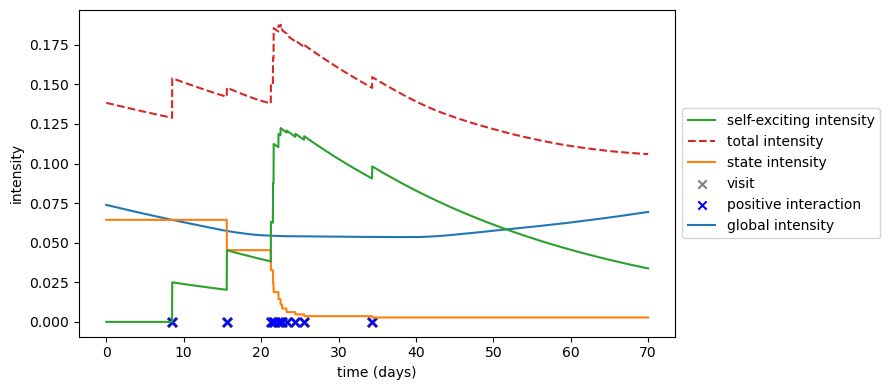

In [40]:
explore_models.plot_rnd_user_visits(42, (1,1,1,1), train_dat, visit_model, train_stg, SETTINGS.hyp,
                         None)